In [15]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds


In [16]:
BATCH_SIZE = 32 

In [17]:
# Load data
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

# Split validate set, training set, and test set
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

In [18]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

In [19]:
def final_model(inputs):

    resnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                           

In [20]:
# Record start time
start_time = time.time()
print('Training started at %s', time.ctime(start_time))

EPOCHS = 40
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data = (x_val, y_val), batch_size=64)


# Record end time
end_time = time.time()
print('Training ended at %s', time.ctime(end_time))

# Calculate duration of training
duration = end_time - start_time
print('Training duration: %i seconds', int(duration))


Training started at %s Thu May 11 13:19:18 2023
Epoch 1/40
907/907 [==============================] - 56s 45ms/step - loss: 0.1760 - accuracy: 0.9496 - val_loss: 0.2359 - val_accuracy: 0.9345
Epoch 2/40
907/907 [==============================] - 39s 43ms/step - loss: 0.0471 - accuracy: 0.9862 - val_loss: 0.0412 - val_accuracy: 0.9885
Epoch 3/40
907/907 [==============================] - 39s 43ms/step - loss: 0.0278 - accuracy: 0.9918 - val_loss: 0.0597 - val_accuracy: 0.9830
Epoch 4/40
907/907 [==============================] - 39s 43ms/step - loss: 0.0172 - accuracy: 0.9945 - val_loss: 0.0315 - val_accuracy: 0.9930
Epoch 5/40
907/907 [==============================] - 39s 43ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0280 - val_accuracy: 0.9935
Epoch 6/40
907/907 [==============================] - 39s 43ms/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.0348 - val_accuracy: 0.9920
Epoch 7/40
907/907 [==============================] - 39s 43ms/step - loss: 0.0077 - acc

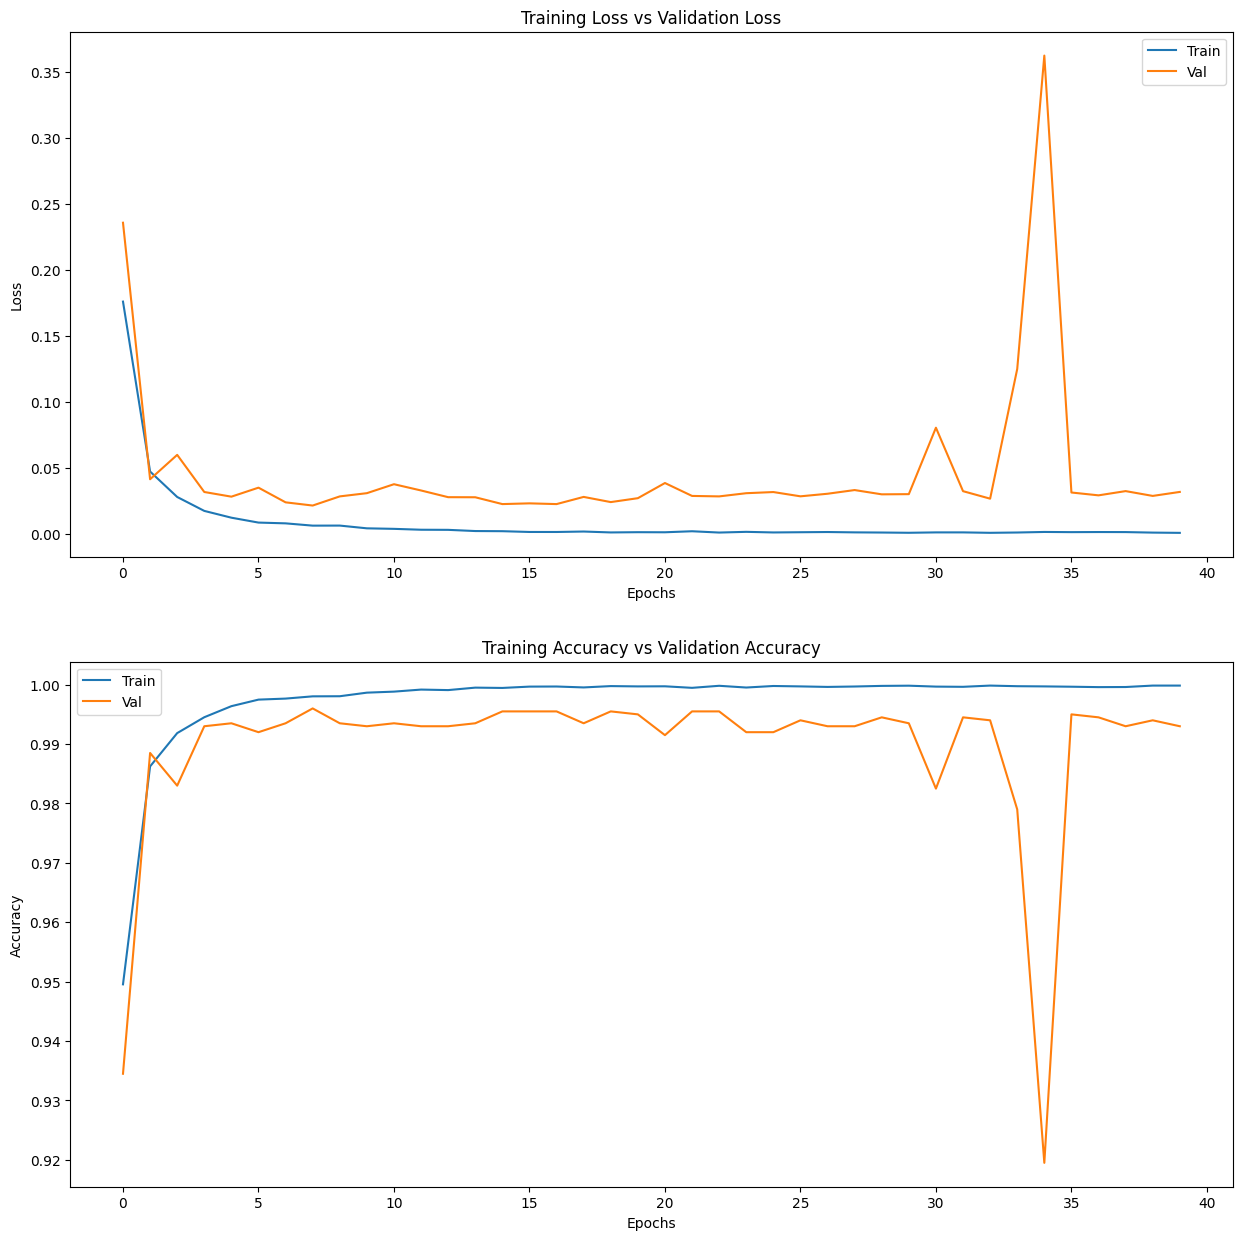

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [22]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 12ms/step - loss: 0.0304 - accuracy: 0.9940


[0.030393114313483238, 0.9940000176429749]